In [27]:
import os
import pandas as pd
import sys
import numpy as np
import seaborn as sns
import time
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torchvision.models as models
from ptflops import get_model_complexity_info

from itertools import product

from src.train.config import Config as ModelConfig
from src.models.pct.point_transformer_cls import get_model as get_pct, get_loss as get_pct_loss
from src.models.pt.model import get_model as get_pt, get_loss as get_pt_loss

# sys.path.append('src')

In [62]:
pretty = { a:b for a,b in zip(['normal','tome_ft','tome_xyz','random'],['base','ToMe on feats','ToMe on coords','Random'])
}


0 pct base 0.8946731234866828
1 pct ToMe on feats 0.8595641646489104
2 pct ToMe on coords 0.8233502538071066
3 pct Random 0.837772397094431
4 pt base 0.5563451776649746
5 pt ToMe on feats 0.4060913705583756
6 pt ToMe on coords 0.4111675126903553
7 pt Random 0.3380710659898477


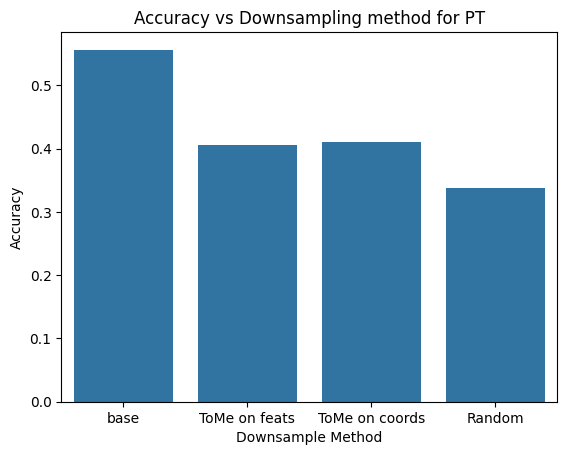

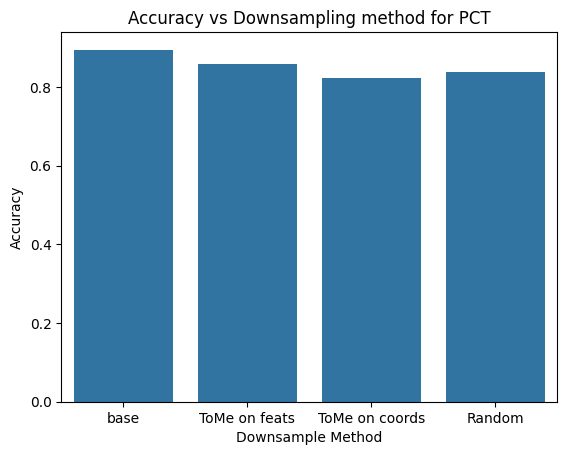

In [112]:
prod = product(['pct','pt'],['base','ToMe on feats','ToMe on coords','Random'])
recs = []
for i, (model, downsample_by) in enumerate(prod):
    subfile = os.path.join(str(i+1), "progress.csv")
    new_version_exists =  (downsample_by == 'ToMe on coords')
    fp = ( os.path.join("outputs/test_v2",subfile)
            if new_version_exists else 
            os.path.join("outputs/test", subfile)
            )
    df = pd.read_csv(fp)
    print(i,model, downsample_by, max(df["V_Accuracy"]))
    recs.append( {
        'Model': model, 
        'Downsample Method':downsample_by,
        'Accuracy':max(df["V_Accuracy"]),
        'F1 score':max(df["V_F1"]),
        'best_iter':df["V_Accuracy"].argmax()
    })

plt.figure()
accs = pd.DataFrame(recs)
ax = sns.barplot(accs[accs['Model'] =='pt'],y='Accuracy',x='Downsample Method')
ax.set_title('Accuracy vs Downsampling method for PT')
ax.get_figure().savefig('figures/new_acc_vs_method_pt.png')

plt.figure()
accs = pd.DataFrame(recs)
ax = sns.barplot(accs[accs['Model'] =='pct'],y='Accuracy',x='Downsample Method')
ax.set_title('Accuracy vs Downsampling method for PCT')
ax.get_figure().savefig('figures/new_acc_vs_method_pct.png')



[('pct', 'base'), ('pct', 'Point Merging on feats'), ('pct', 'Point Merging on coords'), ('pct', 'Random Dowsampling'), ('pt', 'base'), ('pt', 'Point Merging on feats'), ('pt', 'Point Merging on coords'), ('pt', 'Random Dowsampling')]


In [39]:

device = 'cpu'

def get_model(model_name, method, num_points, num_class, input_dim, init_hidden_dim, k, device,further_ds=0):
    model_config = ModelConfig(method, num_points, num_class, input_dim, init_hidden_dim, k,tome_further_ds=1.000-further_ds)
    # print(model_config.tome_further_ds)
    if model_name == "pct":
        model = get_pct(model_config).float().to(device)
        loss_fn = get_pct_loss()
    elif model_name == "pt":
        model = get_pt(model_config).float().to(device)
        loss_fn = get_pt_loss()
    else:
        raise ValueError(f"The provided model_name is not supported: {model_name}")
    
    return model, loss_fn

# model, _ = get_model(
#             model_name='pt', 
#             method='tome_ft', 
#             num_points=1024,
#             num_class=40,
#             input_dim=3,
#             init_hidden_dim=256,
#             k=32,  
#             device='cuda:1',
#             further_ds=0.1,
#         )

# input_tensor = torch.rand(32, 1024, 3).to('cuda:1')
# model(input_tensor)


In [30]:
sys.path.append('src/train')

# from train_model import get_model

model, _ = get_model(
    "pct", 
    "tome_ft", 
    1024,
    40,
    3,
    64,
    32,  
    device
)

input_tensor = torch.rand(32, 1024, 3).to(device)
flops, params = get_model_complexity_info(model, (1024, 3), as_strings=False, print_per_layer_stat=False)

print('mega FLOPs:', flops/(10**6))
print('Million Parameters:', params /(10**6))

mega FLOPs: 558.708008
Million Parameters: 2.752488


In [31]:
model, _ = get_model(
    "pt", 
    "tome_xyz", 
    1024,
    40,
    3,
    32,
    16,  
    device
)

input_tensor = torch.rand(32, 1024, 3).to(device)
flops, params = get_model_complexity_info(model, (1024, 3), as_strings=False, print_per_layer_stat=False)

print('mega FLOPs:', flops/(10**6))
print('Million Parameters:', params /(10**6))


mega FLOPs: 2341.1338
Million Parameters: 7.90564


In [63]:
N = 7

times = []
pbar = tqdm(total=8*N)
for model_name,strat,downsample in product(["pct", "pt"],["normal", "tome_ft", "tome_xyz", "random"],[0.0]):
    if model_name == "pct":
        hidden_size = 64
        k = 32
    else:
        hidden_size = 32
        k = 16

    model, _ = get_model(
        model_name=model_name, 
        method=strat, 
        num_points=1024,
        num_class=40,
        input_dim=3,
        init_hidden_dim=hidden_size,
        k=k,  
        device=device,
        # further_ds=downsample
    )

    flops, params = get_model_complexity_info(model, (1024, 3), as_strings=False, print_per_layer_stat=False)

    for i in range(N):
        input = torch.rand(16, 1024, 3).to(device)
        start = time.time()
        model(input)
        end = time.time()
        times.append({
            'time':end - start, 
            'flops':flops,
            'params':params,
            'Strategy':pretty[strat],
            'model_name':model_name,
            })
        pbar.update()

times_df = pd.DataFrame(times)

100%|██████████| 56/56 [08:03<00:00,  8.64s/it]


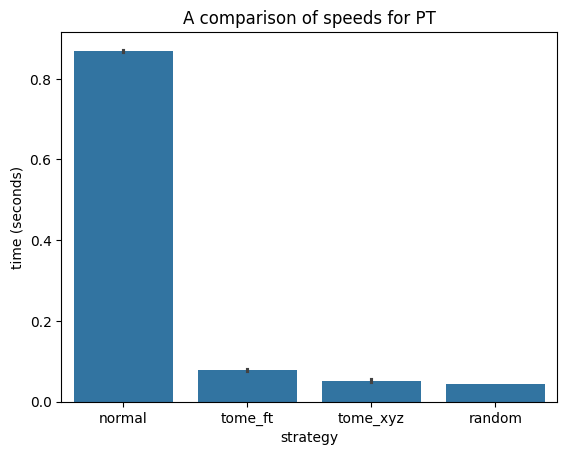

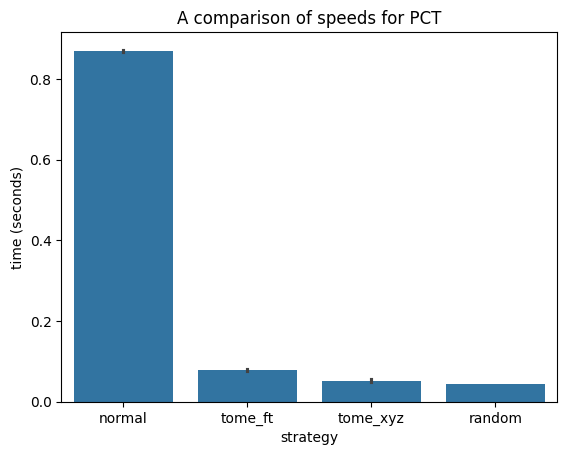

In [59]:
plt.figure()
ax = sns.barplot(times_df[times_df['model_name'] == 'pct'],x='Strategy',y='time')
ax.set(xlabel='strategy', ylabel='time (seconds)')
ax.set(title=f'A comparison of speeds for PT')
ax.get_figure().savefig(f'figures/new_model_speeds_pt_{device}.png')
plt.table(ax)

plt.figure()

ax = sns.barplot(times_df[times_df['model_name'] == 'pct'],x='Strategy',y='time')
ax.set(xlabel='strategy', ylabel='time (seconds)')
ax.set(title=f'A comparison of speeds for PCT')
ax.get_figure().savefig(f'figures/new_model_speeds_pct_{device}.png')

In [109]:
times_accs = times_df.merge(accs,left_on=['Strategy','model_name'],right_on=['Downsample Method','Model'])
times_accs.head()

aggby = {col:'mean' for col in ['Accuracy','F1 score','time','flops',]} 
times_accs_base = times_accs[times_accs['Strategy']== 'base'].groupby('model_name').agg(aggby)
times_accs_base

times_accs_norm = times_accs.copy()
for model_type in ['pt','pct']:
    times_accs_norm.loc[times_accs_norm['model_name'] == model_type, times_accs_base.columns] /= times_accs_base.loc[model_type]
times_accs_norm = times_accs_norm.drop(columns=['params','F1 score']).melt(id_vars = ['Strategy','model_name','Model','Downsample Method','best_iter'])
times_accs_norm = times_accs_norm.sort_index(ascending=False).sort_values('variable',ascending=True)

times_accs_norm.head()

/tmp/ipykernel_1678348/433516323.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.         1.         1.         1.         1.         1.
 1.         0.12651289 0.12651289 0.12651289 0.12651289 0.12651289
 0.12651289 0.12651289 0.12651289 0.12651289 0.12651289 0.12651289
 0.12651289 0.12651289 0.12651289 0.99438803 0.99438803 0.99438803
 0.99438803 0.99438803 0.99438803 0.99438803]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  times_accs_norm.loc[times_accs_norm['model_name'] == model_type, times_accs_base.columns] /= times_accs_base.loc[model_type]


,Strategy,model_name,Model,Downsample Method,best_iter,variable,value
167,Random,pt,pt,Random,5,Accuracy,0.607664
137,Random,pct,pct,Random,29,Accuracy,0.936401
136,Random,pct,pct,Random,29,Accuracy,0.936401
135,Random,pct,pct,Random,29,Accuracy,0.936401
134,Random,pct,pct,Random,29,Accuracy,0.936401


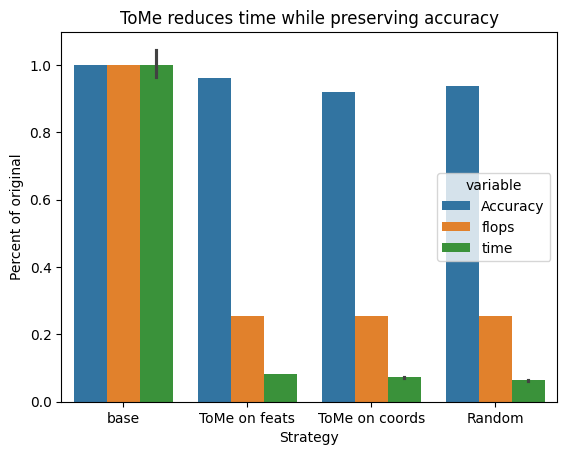

In [111]:
ax = sns.barplot(times_accs_norm[times_accs_norm['model_name'] == 'pct'],x='Strategy',y='value',hue='variable',order=['base', 'ToMe on feats','ToMe on coords','Random'])
ax.set(xlabel='Strategy', ylabel='Percent of original')
ax.set(title=f'ToMe reduces time while preserving accuracy')
ax.get_figure().savefig(f'figures/new_model_accs_speeds.png')


In [35]:
rows = []
models = ["pt",'pct']
devices = ['cuda','cpu']
method =["normal", "tome_ft"]
further_ds = [0.0, 0.15, 0.3]
N_samples = 7 

pbar = tqdm(total=len(models)*len(devices) * len(method) * len(further_ds) * N_samples)
for model_name,device  in product(models, devices):
    # time_dict2[model_name] = dict()

    if model_name == "pct":
        hidden_size = 128
        k = 32
    else:
        hidden_size = 64
        k = 16

    for strat,downsample in product(["normal", "tome_ft",],[0.0, 0.15, 0.3]):
        model, _ = get_model(
            model_name=model_name, 
            method=strat, 
            num_points=1024,
            num_class=40,
            input_dim=3,
            init_hidden_dim=hidden_size,
            k=k,  
            device=device,
            further_ds=downsample
        )
        # print(torch.cuda.memory_allocated(device='cuda'))

        with torch.no_grad(): 
            input_tensor = torch.rand(32, 1024, 3).to(device)
            flops, params = get_model_complexity_info(model, (1024, 3), as_strings=False, print_per_layer_stat=False)
            # print(torch.cuda.memory_allocated(device='cuda'))

            input_tensor = input_tensor.cpu()
            # print(torch.cuda.memory_allocated(device='cuda'))

            for i in range(N_samples):
                input_ = torch.rand(16, 1024, 3).to(device)
                start = time.time()
                model(input_)
                end = time.time()
                # times.append(end - start)
                # print(torch.cuda.memory_allocated(device='cuda'))
                rows.append({
                    'device':device,
                    'model':model_name, 
                    'strategy':strat,
                    'downsample':downsample,
                    'flops':flops,
                    # 'params':params,
                    'time':end - start,
                })
                pbar.update(n=1)
            # print(torch.cuda.memory_allocated(device='cuda'))

        input_ = input_.cpu() 
        model = model.to('cpu')
        del _ 
        del input_tensor
        # print(torch.cuda.memory_allocated(device='cuda'))

del model

100%|██████████| 168/168 [03:12<00:00,  9.45it/s]

In [36]:
# del model, input_, input_tensor, _ 
print(torch.cuda.memory_allocated(device='cuda'))


8519680


In [ ]:
df_sample = pd.DataFrame(rows)
df_sample[['time','flops']] = df_sample[['time','flops']].astype(float)

masks = [(df_sample['model'] == model_) & (df_sample['device'] == device_) for model_, device_ in product(models,devices)]
for mask in masks: 
    bases = df_sample[mask & (df_sample.strategy == 'normal') & (df_sample.downsample == 0.00)]
    bases = bases[['time','flops',]].mean()

    df_sample.loc[mask,['time','flops']] = df_sample.loc[mask,['time','flops']] / bases

df_sample

,device,model,strategy,downsample,flops,time
0,cuda,pt,normal,0.0,1.000000,2.164204
1,cuda,pt,normal,0.0,1.000000,0.819420
2,cuda,pt,normal,0.0,1.000000,0.816034
3,cuda,pt,normal,0.0,1.000000,0.805402
4,cuda,pt,normal,0.0,1.000000,0.797579
...,...,...,...,...,...,...
163,cpu,pct,tome_ft,0.3,0.129204,0.052032
164,cpu,pct,tome_ft,0.3,0.129204,0.052341
165,cpu,pct,tome_ft,0.3,0.129204,0.052993
166,cpu,pct,tome_ft,0.3,0.129204,0.052489


/tmp/ipykernel_943792/1796915253.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


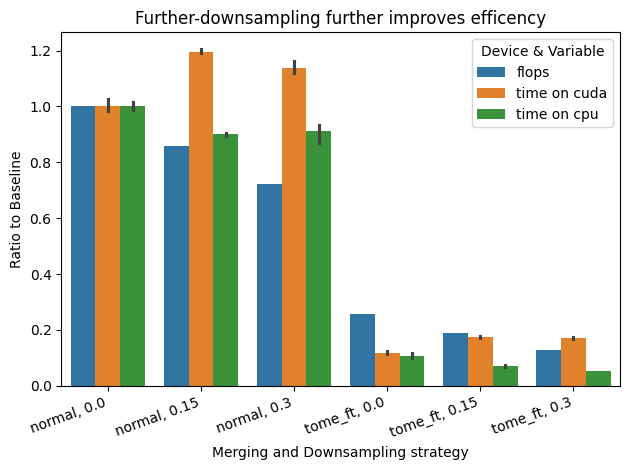

In [9]:
# melted2 = pd.DataFrame(time_dict2).reset_index().rename(columns={'level_0':'agg','level_1':'downsample'}).explode(column=['pct','pt']).melt(id_vars = ['agg','downsample']).rename(columns={'value':'Time'})#.explode(column='value').reset_index(drop=True)
melted2 = df_sample.rename(columns={'strategy':'agg'}).melt(id_vars=['model','agg','downsample','device'],value_name='Ratio to Baseline')
melted2['Merging and Downsampling strategy'] = melted2.apply((lambda row: (f'{row["agg"]}, {row["downsample"]}')),axis=1)
melted2['Device & Variable'] = melted2.apply((lambda row: f'{row["variable"]} on {row["device"]}' if row['variable'] !='flops' else 'flops'),axis=1)
ax = sns.barplot(melted2[melted2['model'] == 'pct'],x='Merging and Downsampling strategy',y='Ratio to Baseline',hue='Device & Variable')
ax.set(title=f'Further-downsampling further improves efficency')
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=20, 
    horizontalalignment='right'
)
ax.get_figure().tight_layout()
ax.get_figure().savefig(f'figures/downsample_speeds_pct_both_devs.png')
print()
# melted2

/tmp/ipykernel_942082/1160579061.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


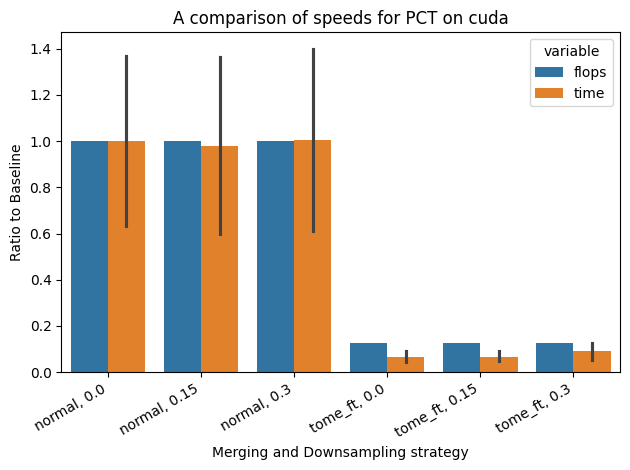

In [12]:
# ax.set(xlabel='strategy', ylabel='time (seconds)')
ax = sns.barplot(melted2[melted2['model'] == 'pt'],x='Merging and Downsampling strategy',y='Ratio to Baseline',hue='variable')
ax.set(title=f'A comparison of speeds for PCT on {device}')
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=30, 
    horizontalalignment='right'
)
ax.get_figure().tight_layout()
ax.get_figure().savefig(f'figures/downsample_speeds_pt_{device}.png')
print()

In [14]:
melted2

,model,agg,downsample,device,variable,Ratio to Baseline,Merging and Downsampling strategy
0,pct,normal,0.0,cpu,flops,1.000000,"normal, 0.0"
1,pct,normal,0.0,cpu,flops,1.000000,"normal, 0.0"
2,pct,normal,0.0,cpu,flops,1.000000,"normal, 0.0"
3,pct,normal,0.0,cpu,flops,1.000000,"normal, 0.0"
4,pct,normal,0.0,cpu,flops,1.000000,"normal, 0.0"
...,...,...,...,...,...,...,...
331,pt,tome_ft,0.3,cuda,time,0.023414,"tome_ft, 0.3"
332,pt,tome_ft,0.3,cuda,time,0.023420,"tome_ft, 0.3"
333,pt,tome_ft,0.3,cuda,time,0.023274,"tome_ft, 0.3"
334,pt,tome_ft,0.3,cuda,time,0.023351,"tome_ft, 0.3"
